In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [2]:
df_train = pd.read_csv('F:/Titanic/data/train.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


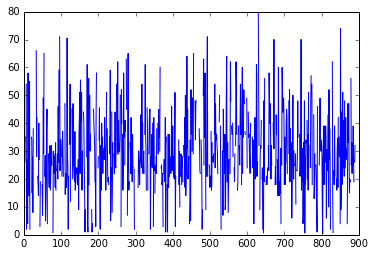

In [5]:
plt.plot(range(0, len(df_train['Age'])),df_train['Age'])

In [6]:
# Fractional age is converted to float values by multiplying 100
df_train.loc[df_train['Age']<1,'Age'] = df_train.loc[df_train['Age']<1,'Age']*100
print len(df_train.loc[df_train['Age']<1,'Age'])
min(df_train['Age'])

0


1.0

In [7]:

# df_train['Age']= df_train['Age'].fillna(float(df_train['Age'].mode())) # fill na by median Age

for i in df_train.columns:
    
    if(i in ['PassengerId','Name']):
        pass
    else:
        print i
        df_train[i]= df_train[i].fillna(df_train[i].mode()[0]) # fill na by mode Values

Survived
Pclass
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


In [8]:
del(df_train['PassengerId'])
del(df_train['Name'])

In [9]:
import h2o

In [10]:
h2o.init(max_mem_size='6G')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.121-b13, mixed mode)
  Starting server from C:\Users\hamza\Anaconda3\envs\gl-env\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: c:\users\hamza\appdata\local\temp\tmpi5qxme
  JVM stdout: c:\users\hamza\appdata\local\temp\tmpi5qxme\h2o_hamza_started_from_python.out
  JVM stderr: c:\users\hamza\appdata\local\temp\tmpi5qxme\h2o_hamza_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,05 secs
H2O cluster version:,3.10.3.4
H2O cluster version age:,27 days
H2O cluster name:,H2O_from_python_hamza_7k64wn
H2O cluster total nodes:,1
H2O cluster free memory:,5.333 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [11]:
hdf = h2o.H2OFrame(df_train)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [12]:
hdf['Survived']= hdf['Survived'].asfactor()

In [13]:
hdf_train, hdf_validate = hdf.split_frame([0.70], seed=100)

In [14]:
input_col = hdf.col_names
input_col.remove('Survived')
print input_col

[u'Pclass', u'Sex', u'Age', u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked']


In [15]:
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator

In [16]:
nb =H2ONaiveBayesEstimator(seed =1, nfolds = 50)
nb.train(x =input_col, y = 'Survived', training_frame=hdf_train, validation_frame=hdf_validate)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


Train accuracy: 0.843534482759
valid accuracy: 0.810875512996


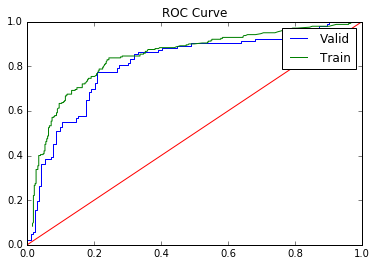

In [17]:
def model_performance(model =  nb):
    print 'Train accuracy:', model.auc(train=True)
    print 'valid accuracy:', model.auc(valid=True)

    roc_valid = model.roc(valid=True)
    roc_train= model.roc()

    plt.plot(roc_valid[0],roc_valid[1])
    plt.plot(roc_train[0],roc_train[1])
    plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1))
    
    plt.title('ROC Curve')
    plt.legend(['Valid','Train'])
    plt.show()

model_performance()

In [18]:
# This model is less bais to overfitting
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [19]:
gbm_model = H2OGradientBoostingEstimator(seed =1, nfolds =10)
gbm_model.train(x =input_col, y = 'Survived', training_frame=hdf_train, validation_frame=hdf_validate)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


Train accuracy: 0.978879310345
valid accuracy: 0.84624373005


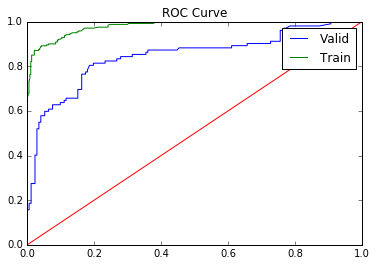

In [20]:
model_performance(gbm_model)

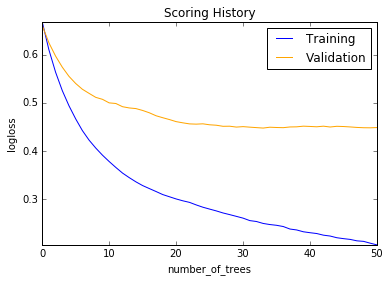

In [21]:
gbm_model.plot()

In [22]:
gbm_model = H2OGradientBoostingEstimator(seed =1, nfolds =10)
gbm_model.train(x =input_col, y = 'Survived', training_frame=hdf_train, validation_frame=hdf_validate)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


Train accuracy: 0.978879310345
valid accuracy: 0.84624373005


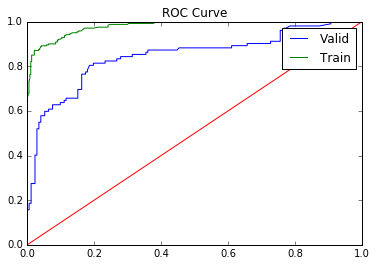

In [23]:
model_performance(gbm_model)

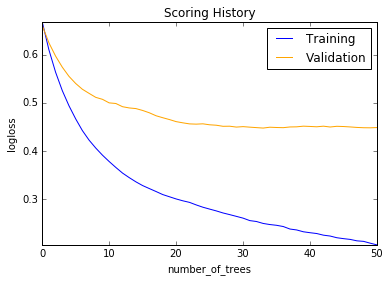

In [24]:
gbm_model.plot()

In [25]:
 from h2o.estimators.random_forest import H2ORandomForestEstimator

In [26]:
rf = H2ORandomForestEstimator(seed =1)
rf.train(x =input_col, y = 'Survived', training_frame=hdf_train, validation_frame=hdf_validate)

drf Model Build progress: |███████████████████████████████████████████████| 100%


Train accuracy: 0.883791998232
valid accuracy: 0.860351117191


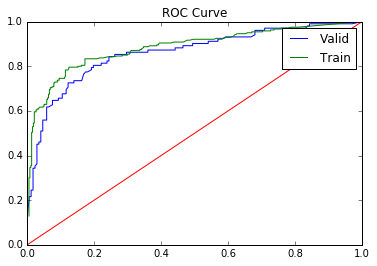

In [27]:
model_performance(rf)

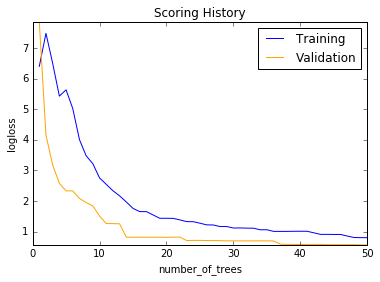

In [28]:
rf.plot()

In [29]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

In [30]:
dl = H2ODeepLearningEstimator(seed =1,epochs =700,hidden=[50,50,50,50], model_id='dl1')
dl.train(x =input_col, y = 'Survived', training_frame=hdf_train, validation_frame=hdf_validate)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


Train accuracy: 0.854907161804
valid accuracy: 0.78317373461


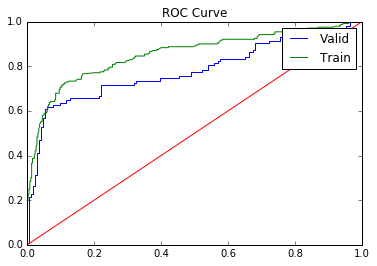

In [31]:
model_performance(dl)

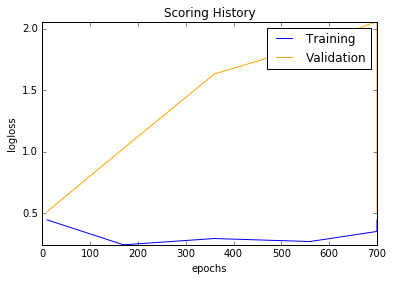

In [32]:
dl.plot()

In [46]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [49]:
model_glm = H2OGeneralizedLinearEstimator(seed =1, family = 'binomial')
model_glm.train(x =input_col, y = 'Survived', training_frame=hdf_train, validation_frame=hdf_validate)

glm Model Build progress: |███████████████████████████████████████████████| 100%


Train accuracy: 0.844916003537
valid accuracy: 0.826037391701


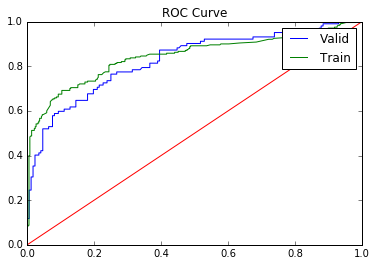

In [50]:
model_performance(model_glm)

# Prediction 

Now load test data and do same preprocessing as on training set and then do predictions

In [34]:
df_test = pd.read_csv('F:/Titanic/data/test.csv')

In [35]:
del(df_test['PassengerId'])
del(df_test['Name'])

In [36]:
# Fractional age is converted to float values by multiplying 100
df_test.loc[df_test['Age']<1,'Age'] = df_test.loc[df_test['Age']<1,'Age']*100
print len(df_test.loc[df_test['Age']<1,'Age'])
min(df_test['Age'])

0


1.0

In [37]:
for i in df_test.columns:
    
    if(i in ['PassengerId','Name']):
        pass
    else:
        print i
        df_test[i]= df_test[i].fillna(df_test[i].mode()[0]) # fill na by mode Values

Pclass
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


In [38]:
hdf_test = h2o.H2OFrame(df_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [39]:
def get_prediction(model= gbm_model, hdf_data = hdf_test, create_frame=True):
    prediction = model.predict(hdf_data)
    
    if(create_frame == True):
        lst_id=range(892,len(df_test['Age'])+892)

        #initialize dataframe and save prediction values in Survived columns and lst_id in Passenger id coloums
        df_submission = pd.DataFrame()
        df_submission['PassengerId'] = lst_id
        df_submission['Survived'] = prediction['predict'].as_data_frame()
        
        return df_submission

    else:
    #     prediction['predict'].unique()
        return prediction

In [40]:
df_submission = get_prediction(gbm_model)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [41]:
df_submission.to_csv('F:/Titanic/data/submission.csv',index=False)

In [42]:
def show_percentile(column = 'Fare', lower_bound = 7.910400, upper_bound = 31.0, count = True):
    if (count):
        print 'lower bound count: ', df_train.loc[df_train[column] < lower_bound, column].count()
        print 'upper bound count: ', df_train.loc[df_train[column] > upper_bound, column].count()

    plt.title((column +' Box Plot'))
    plt.boxplot(df_train[column])
    plt.show()



lower bound count:  157
upper bound count:  184


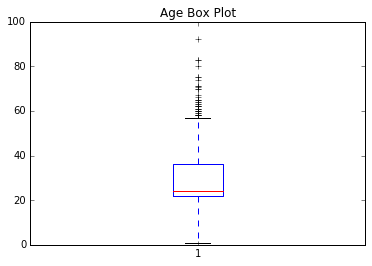

In [43]:
show_percentile(column='Age', lower_bound= 20, upper_bound=38) 

## Fare, cabin, class and ticket

lower bound count:  223
upper bound count:  222


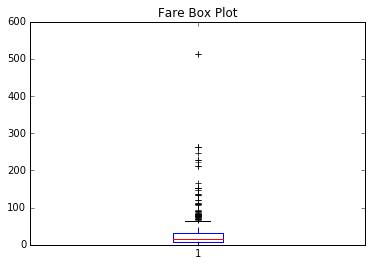

In [44]:
show_percentile()

lower bound count:  0
upper bound count:  0


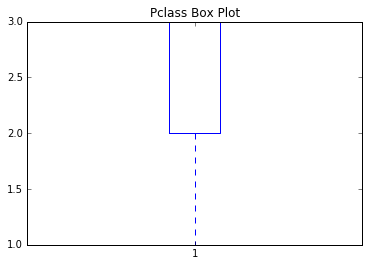

In [45]:
show_percentile(column='Pclass', lower_bound=1,upper_bound=3)